In [ ]:
# !pip install --upgrade mplfinance
# !pip install yfinance
# !pip install hvplot
# !pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.4 MB/s 


In [26]:
from mplfinance.original_flavor import candlestick_ohlc # pip install --upgrade mplfinance
import yfinance as yf  # pip install yfinance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import boxcox
from itertools import product
from tqdm import tqdm_notebook
from pandas.plotting import autocorrelation_plot
import hvplot

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def get_price_data(ticker='TSLA'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2022-1-1')
    return tickerDf.iloc[:, :5]

In [3]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(25, 10))
    
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=30, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=30, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Анализ листинга компании ENI

In [6]:
df_eni = get_price_data(ticker='E')

In [7]:
df_eni.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,23.282800,23.367954,23.041528,23.176355,508500
2017-01-04 00:00:00-05:00,23.069909,23.311182,23.055719,23.289894,226600
2017-01-05 00:00:00-05:00,23.417630,23.687288,23.389244,23.566650,185700
2017-01-06 00:00:00-05:00,23.304085,23.573743,23.289892,23.495684,141400
2017-01-09 00:00:00-05:00,23.091201,23.155068,22.956371,22.963469,389100


<AxesSubplot:xlabel='Date', ylabel='OHLC'>

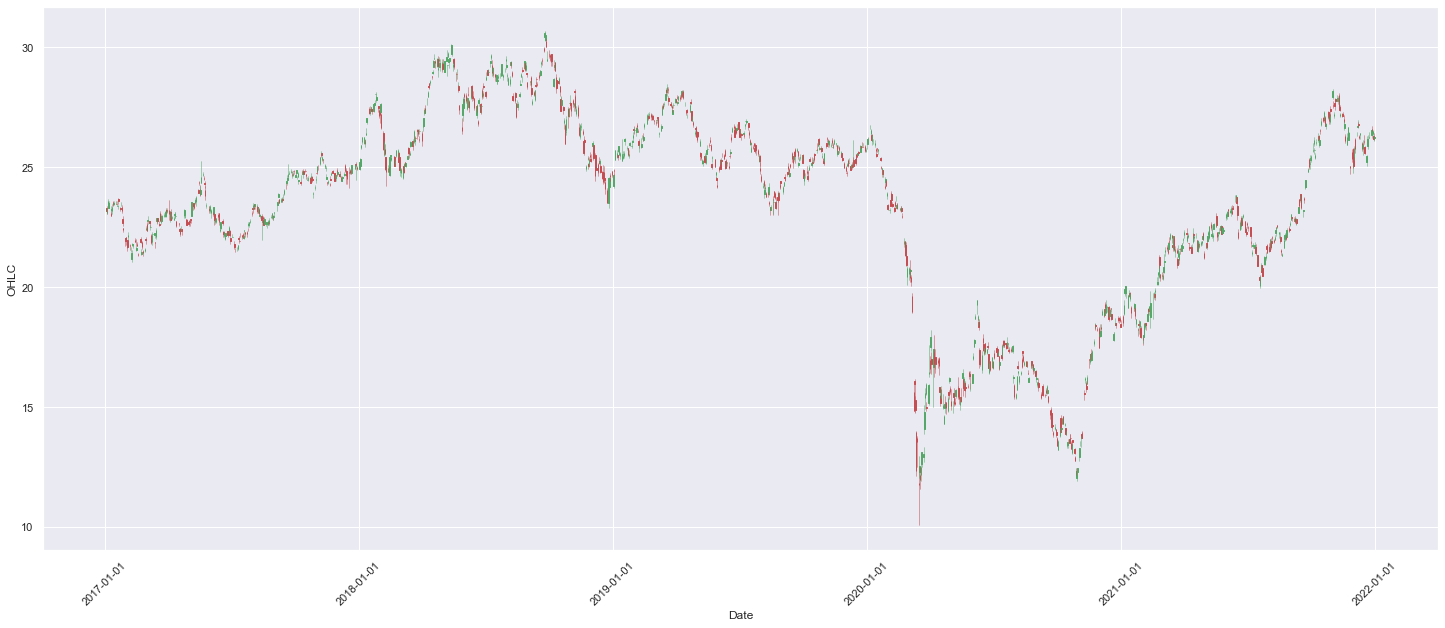

In [8]:
plot_candlestick(df_eni)

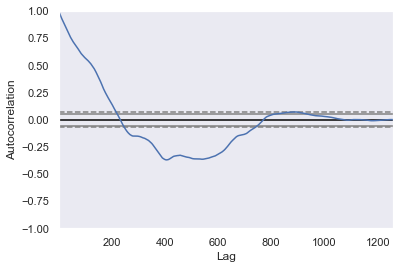

In [9]:
autocorrelation_plot(df_eni['Close'])
plt.show()

Максимальным оказался коэффициент автокорреляции 1 порядка, т.е. временной ряд содержит сильный тренд. Но также, коэффициент автокорреляции порядка 500 является значимым, т.е. присутствует циклические колебания с периодичностью в 500 дней.

Results of Dickey-Fuller Test:
Test Statistic                   -1.630821
p-value                           0.467061
#Lags Used                       18.000000
Number of Observations Used    1240.000000
Critical Value (1%)              -3.435635
Critical Value (5%)              -2.863874
Critical Value (10%)             -2.568012
dtype: float64


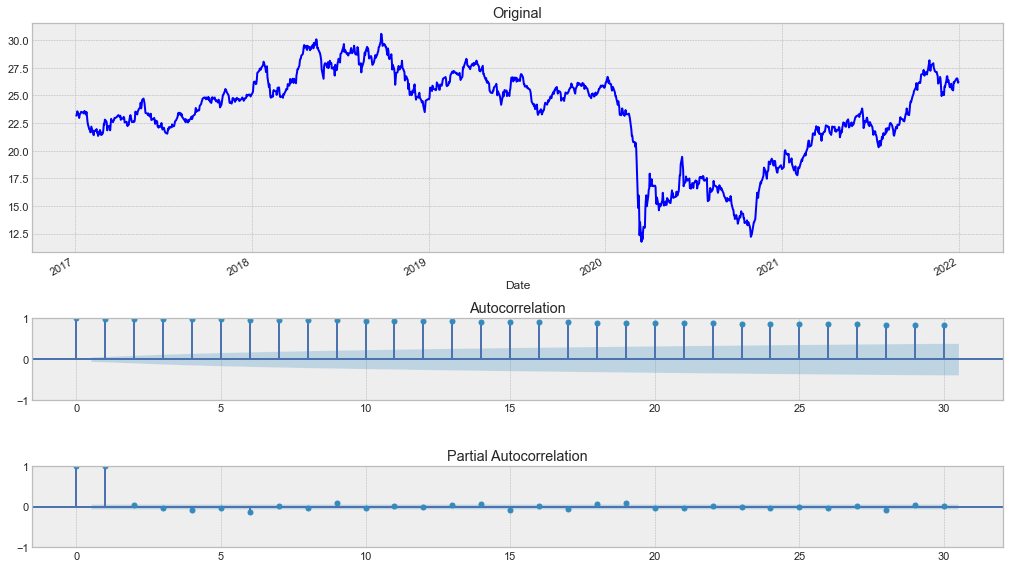

In [10]:
tsplot(df_eni['Close'])

Учитывая тест Дики-Фуллера и графики коррелограмм, гипотеза о нестационарности ряда не может быть отвергнута. Необходимо убрать размах дисперсии при помощи преобразования Бокса-Кокса

Results of Dickey-Fuller Test:
Test Statistic                   -1.764193
p-value                           0.398378
#Lags Used                       20.000000
Number of Observations Used    1238.000000
Critical Value (1%)              -3.435643
Critical Value (5%)              -2.863877
Critical Value (10%)             -2.568014
dtype: float64


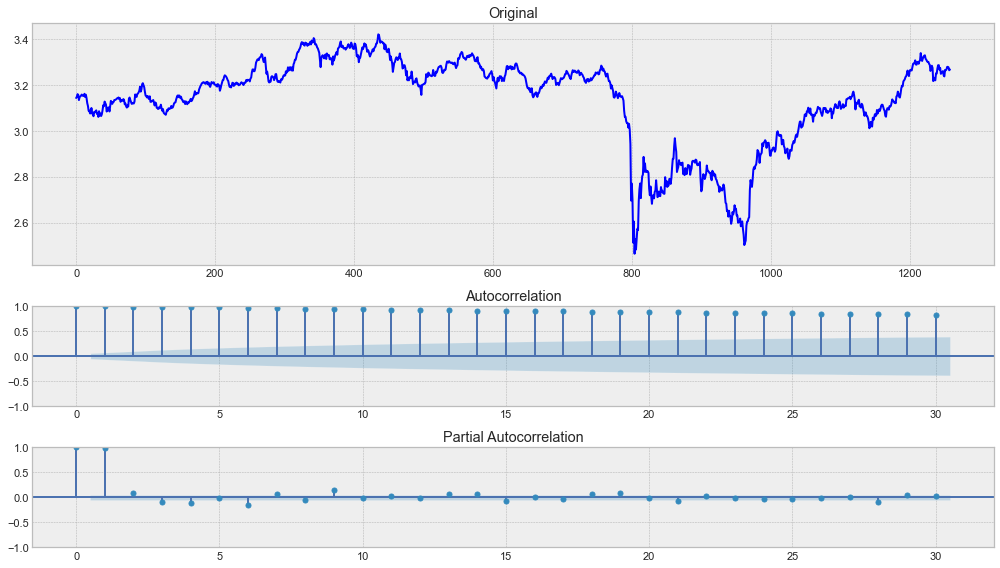

In [11]:
series_eni = boxcox(df_eni['Close'], 0)
tsplot(series_eni)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Устранить его можно дифференцированием.

Results of Dickey-Fuller Test:
Test Statistic                -9.586953e+00
p-value                        2.084906e-16
#Lags Used                     1.700000e+01
Number of Observations Used    1.240000e+03
Critical Value (1%)           -3.435635e+00
Critical Value (5%)           -2.863874e+00
Critical Value (10%)          -2.568012e+00
dtype: float64


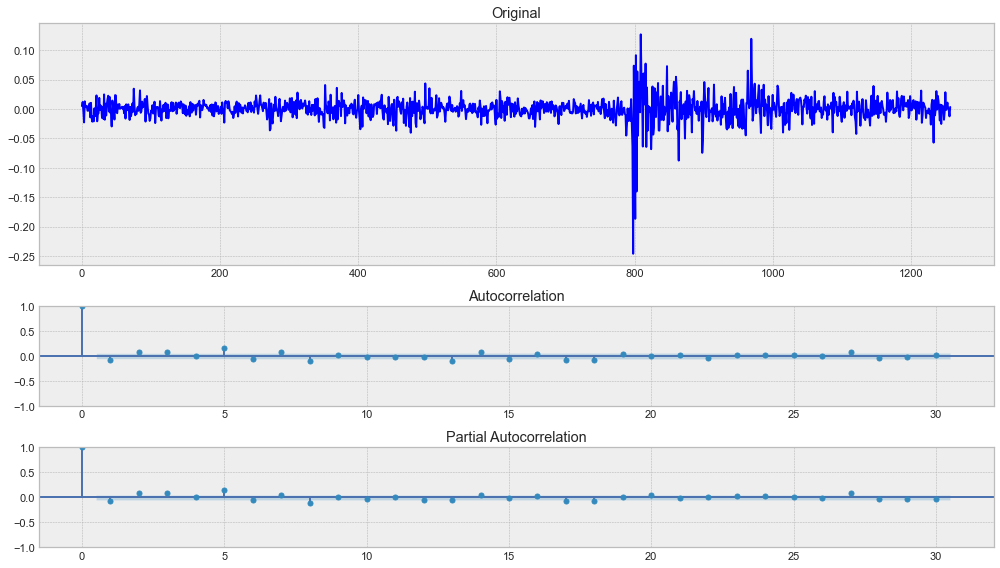

In [12]:
series_eni_dif = series_eni[1:] - series_eni[:-1]
tsplot(series_eni_dif)

Теперь тест Дики-Фуллера (p-value = 2.084927e-16) и графики коррелограмм отвергают гипотезу о нестационарности ряда

# Анализ листинга компании NOKIA

In [13]:
df_nokia = get_price_data(ticker='NOK')

In [14]:
df_nokia.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,4.314230,4.341421,4.305167,4.323294,7883000
2017-01-04 00:00:00-05:00,4.350484,4.395802,4.341421,4.386738,10247100
2017-01-05 00:00:00-05:00,4.395802,4.459247,4.377675,4.441120,9878400
2017-01-06 00:00:00-05:00,4.468310,4.522691,4.441120,4.459247,18078800
2017-01-09 00:00:00-05:00,4.404866,4.422993,4.332358,4.377675,14555100


<AxesSubplot:xlabel='Date', ylabel='OHLC'>

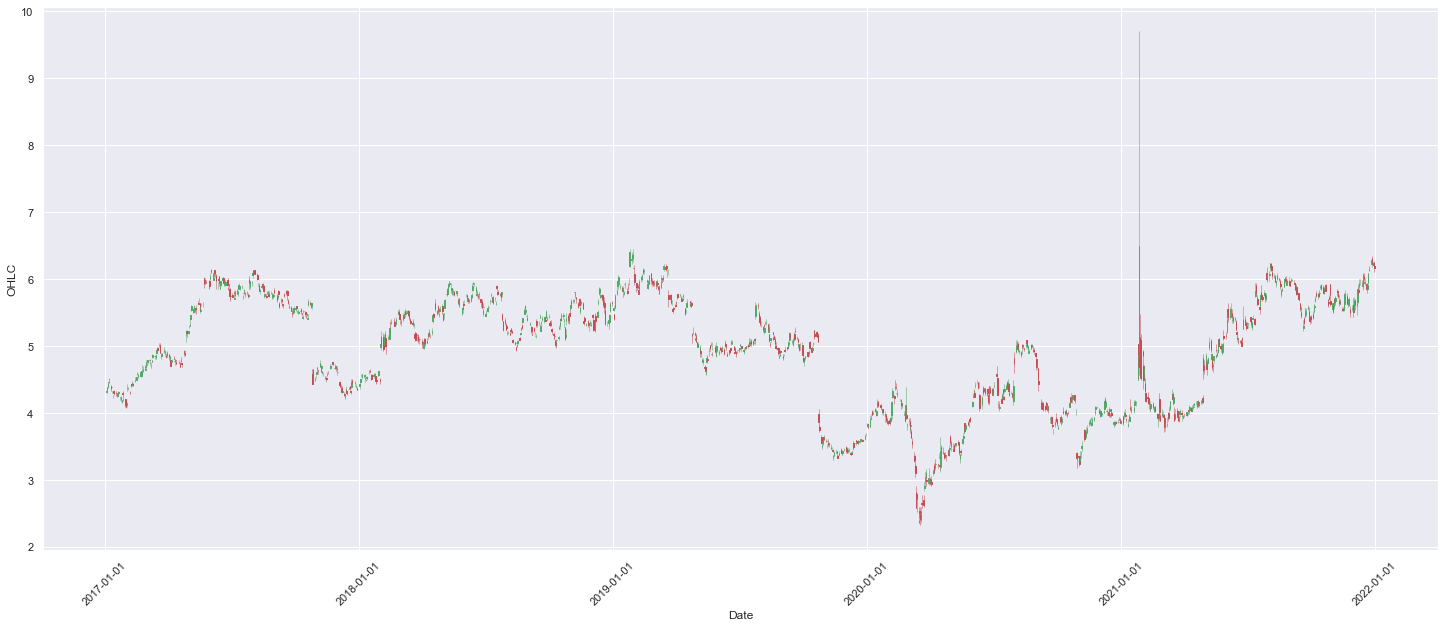

In [15]:
plot_candlestick(df_nokia)

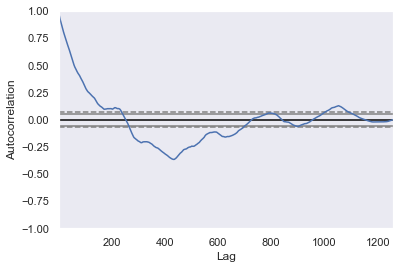

In [16]:
autocorrelation_plot(df_nokia['Close'])
plt.show()

Аналогично с ENI, максимальным оказался коэффициент автокорреляции 1 порядка, т.е. временной ряд содержит сильный тренд. Также, коэффициент автокорреляции порядка 400-420 является значимым, т.е. присутствует циклические колебания с периодичностью в чуть больше чем год.

Results of Dickey-Fuller Test:
Test Statistic                   -2.287867
p-value                           0.175911
#Lags Used                        4.000000
Number of Observations Used    1254.000000
Critical Value (1%)              -3.435575
Critical Value (5%)              -2.863848
Critical Value (10%)             -2.567999
dtype: float64


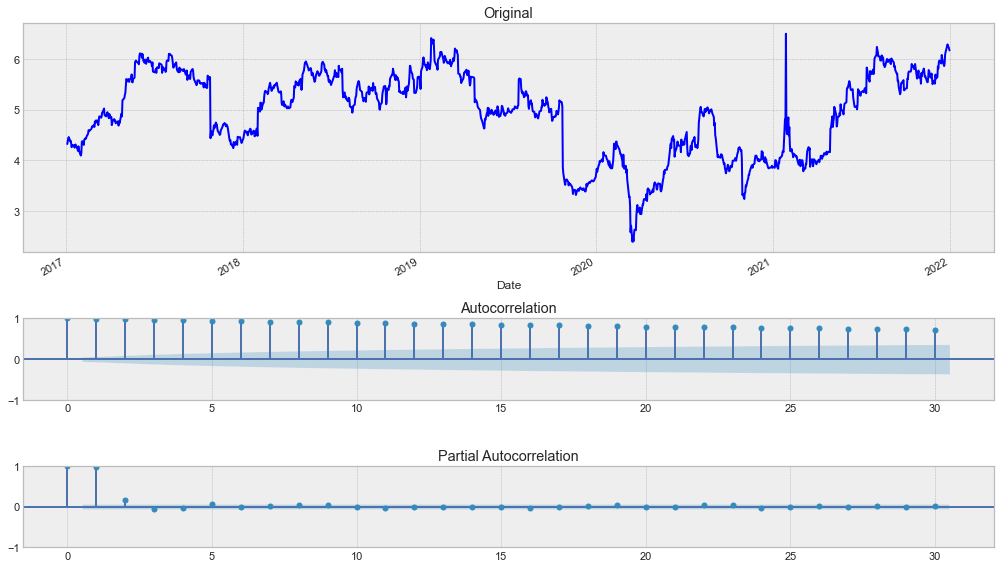

In [17]:
tsplot(df_nokia['Close'])

Гипотеза о нестационарности ряда не может быть отвергнута учитывая тест Дики-Фуллера и графики. Необходимо убрать размах дисперсии при помощи преобразования Бокса-Кокса

Results of Dickey-Fuller Test:
Test Statistic                   -2.459552
p-value                           0.125628
#Lags Used                        4.000000
Number of Observations Used    1254.000000
Critical Value (1%)              -3.435575
Critical Value (5%)              -2.863848
Critical Value (10%)             -2.567999
dtype: float64


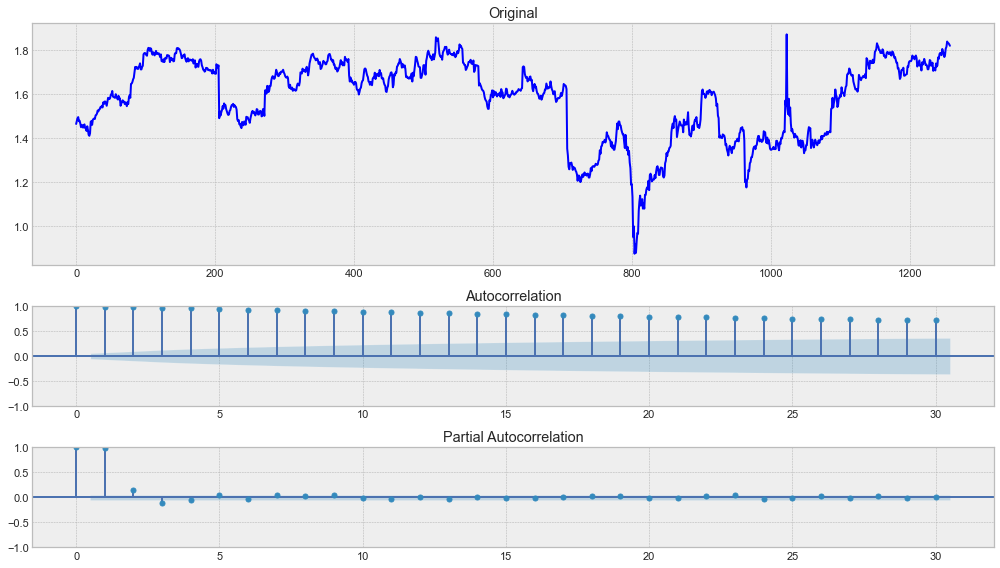

In [18]:
series_nokia = boxcox(df_nokia['Close'], 0)
tsplot(series_nokia)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Устранить его можно дифференцированием.

Results of Dickey-Fuller Test:
Test Statistic                -1.787155e+01
p-value                        3.026262e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.254000e+03
Critical Value (1%)           -3.435575e+00
Critical Value (5%)           -2.863848e+00
Critical Value (10%)          -2.567999e+00
dtype: float64


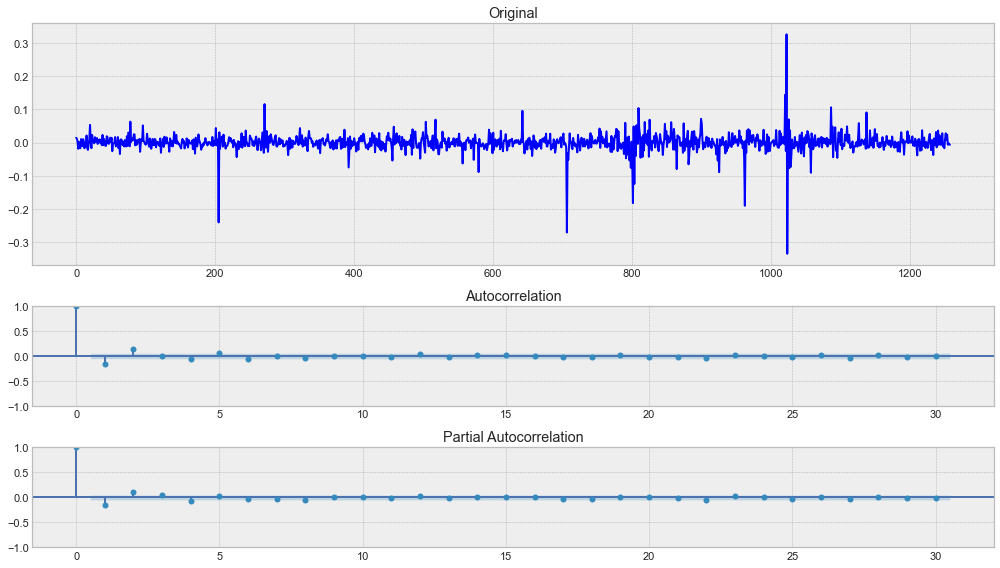

In [19]:
series_nokia_dif = series_nokia[1:] - series_nokia[:-1]
tsplot(series_nokia_dif)

Теперь тест Дики-Фуллера (p-value = 3.026260e-30) и графики коррелограмм отвергают гипотезу о нестационарности ряда

По обеим компаниям можно предположить следующее: 
периоичные колебания в 400-450 дней обусловлены мировыми событиями: начало и новые волны пандемии коронавируса, войны, инаугурация Байдена с захватом Капитолия и т.д. Для этого необходимо сопоставить историю новостей с колебаниями на рынке

# Задание 2

Для прогноза был выбран Prophet, так как позволяет быстро и достаточно качественно автоматически строить прогнозы временныз рядов, удобна для использования и не нужно сильно предобрабатывать данные

In [20]:
eni = df_eni.copy()
# number of future predictions
predictions = 180

Необходимо предобработать данные для заполнения пропусков по дням

In [21]:
eni = eni.reindex(pd.date_range(start=eni.index.min(),
                                                  end=eni.index.max(),
                                                  freq='1D'))
eni = eni.interpolate(method='linear')
eni = eni.reset_index()

df = eni[['index', 'Close']]
df.columns = ['ds', 'y']
df['ds'] = df['ds'].dt.date
df.tail()

,ds,y
1819,2021-12-27,26.533663
1820,2021-12-28,26.552643
1821,2021-12-29,26.486214
1822,2021-12-30,26.154068
1823,2021-12-31,26.239477


In [22]:
train_df = df[:-predictions]

In [27]:
model = Prophet()
model.fit(train_df)

23:13:50 - cmdstanpy - INFO - Chain [1] start processing
23:13:51 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = model.make_future_dataframe(periods=predictions,
                                     freq='D')

# finally, making predictions
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1819,2021-12-27,26.266957,22.501583,29.613557,23.244819,29.600560,-0.423132,-0.423132,-0.423132,-0.011516,-0.011516,-0.011516,-0.411617,-0.411617,-0.411617,0.0,0.0,0.0,25.843824
1820,2021-12-28,26.287889,22.408434,29.608081,23.227334,29.646324,-0.315522,-0.315522,-0.315522,0.031822,0.031822,0.031822,-0.347344,-0.347344,-0.347344,0.0,0.0,0.0,25.972367
1821,2021-12-29,26.308821,22.758703,29.583823,23.209849,29.693167,-0.237705,-0.237705,-0.237705,0.039004,0.039004,0.039004,-0.276709,-0.276709,-0.276709,0.0,0.0,0.0,26.071116
1822,2021-12-30,26.329753,22.822229,29.689397,23.192364,29.734631,-0.202760,-0.202760,-0.202760,-0.002566,-0.002566,-0.002566,-0.200193,-0.200193,-0.200193,0.0,0.0,0.0,26.126994
1823,2021-12-31,26.350686,22.855387,29.713980,23.174879,29.774403,-0.139511,-0.139511,-0.139511,-0.021067,-0.021067,-0.021067,-0.118444,-0.118444,-0.118444,0.0,0.0,0.0,26.211174


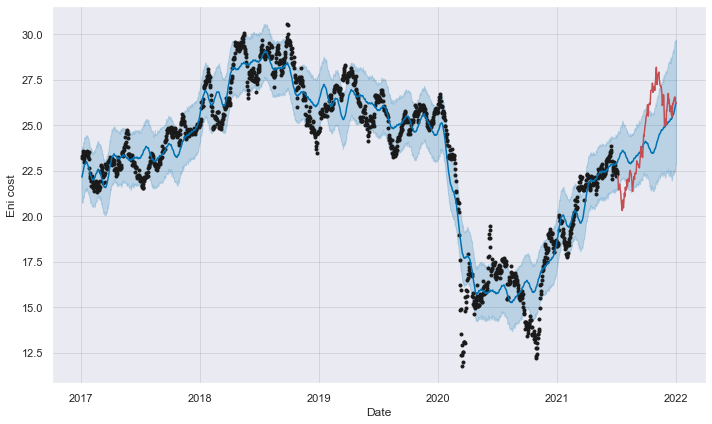

In [29]:
fig = model.plot(forecast, xlabel='Date',
                 ylabel=r'Eni cost')

plt.plot(df[-predictions:].ds, df[-predictions:].y, color='r')
plt.show()

In [30]:
# немного добавим интерактива
plot_plotly(model, forecast)

In [31]:
plot_components_plotly(model, forecast)

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))


Mean absolute percentage error 6.34%


В целом, при валидации модели получилось вполне допустимое значение MAPE. Это значит что можно построить прогноз на ближайший год

In [34]:
model_year = Prophet()

model_year.fit(df)

future_year = model_year.make_future_dataframe(periods=365,
                                     freq='D')
# finally, making predictions
forecast_year = model_year.predict(future_year)
forecast_year.tail()

23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2184,2022-12-27,36.822710,28.097852,45.137076,28.230110,44.946051,-0.082433,-0.082433,-0.082433,0.035414,0.035414,0.035414,-0.117847,-0.117847,-0.117847,0.0,0.0,0.0,36.740277
2185,2022-12-28,36.848580,28.088971,45.531751,28.213013,45.015556,-0.013135,-0.013135,-0.013135,0.038372,0.038372,0.038372,-0.051507,-0.051507,-0.051507,0.0,0.0,0.0,36.835445
2186,2022-12-29,36.874451,28.265940,45.213132,28.201848,45.086648,0.016888,0.016888,0.016888,-0.004812,-0.004812,-0.004812,0.021700,0.021700,0.021700,0.0,0.0,0.0,36.891338
2187,2022-12-30,36.900321,28.494257,45.331096,28.204955,45.159864,0.073366,0.073366,0.073366,-0.027926,-0.027926,-0.027926,0.101292,0.101292,0.101292,0.0,0.0,0.0,36.973687
2188,2022-12-31,36.926191,28.670076,45.081607,28.191882,45.229706,0.168632,0.168632,0.168632,-0.017982,-0.017982,-0.017982,0.186614,0.186614,0.186614,0.0,0.0,0.0,37.094824


In [35]:
plot_plotly(model_year, forecast_year)

Как видим из графика, модель предсказывает рост, однако февраль 2022 явно внес свои существенные коррективы)

## Задание 3

In [36]:
wind = pd.read_csv('data.csv')
wind['dt'] = pd.to_datetime(wind['dt'])

In [37]:
wind.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


Усредненим данные по месяцам для уменьшения размера датасета, а также из-за того что выработка электроэнергии имеет сезонность связанную с потреблением, которое меняется в течение года в зависимости от поры года

In [38]:
wind_month = wind.copy()
wind_month['YearMonth'] = wind_month['dt'].apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
wind_month = wind_month.groupby('YearMonth').mean()
wind_month = wind_month.reset_index()
wind_month.columns = ['ds', 'y']
wind_month['ds'] = pd.to_datetime(wind_month['ds'])
wind_month = wind_month.sort_values(by="ds")
wind_month.head()


,ds,y
0,2011-01-01,1597.289987
4,2011-02-01,1674.951637
5,2011-03-01,1665.180013
6,2011-04-01,1665.061458
7,2011-05-01,1878.650874


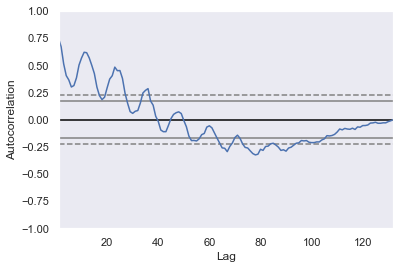

In [39]:
autocorrelation_plot(wind_month['y'])
plt.show()

На автокореллограмме явно есть тренд и значимые циклические колебания

Results of Dickey-Fuller Test:
Test Statistic                  -1.286391
p-value                          0.635375
#Lags Used                      10.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


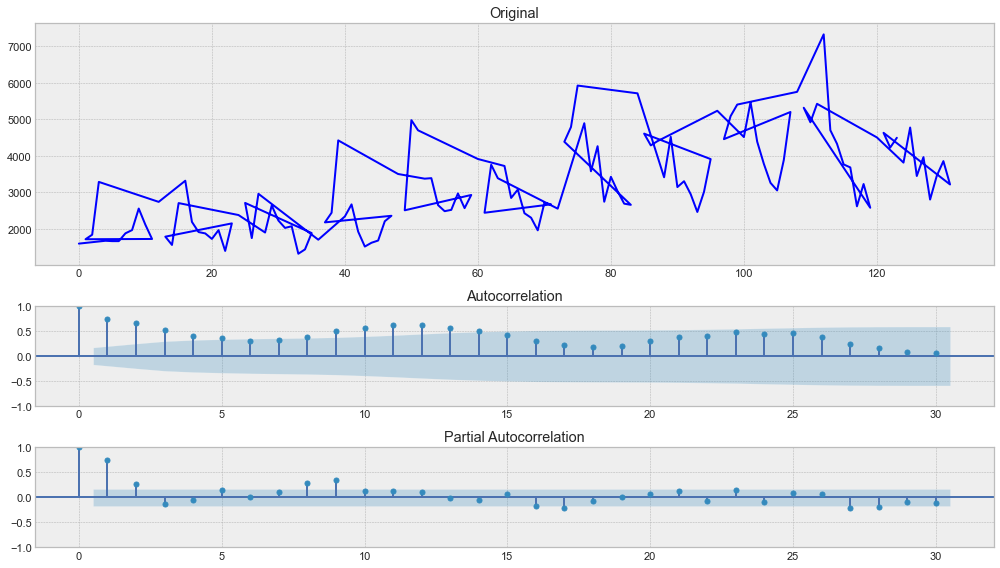

In [40]:
tsplot(wind_month['y'], lags=30)

Гипотеза о нестационарности ряда не может быть отвергнута учитывая тест Дики-Фуллера и графики (без понятия почему он такой ломаный, перепробовал всё что мог, дальше он будет в порядке)

Уберем размах дисперсии

In [41]:
series_wind = boxcox(wind_month['y'], 0)

Results of Dickey-Fuller Test:
Test Statistic                  -0.948284
p-value                          0.771657
#Lags Used                      11.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


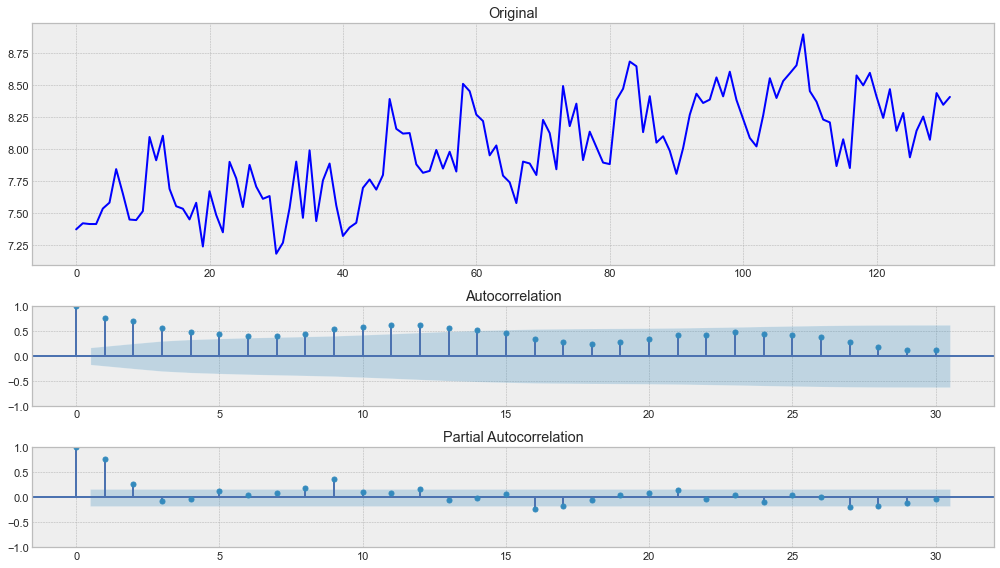

In [42]:
tsplot(series_wind)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Устранить его можно дифференцированием.

Results of Dickey-Fuller Test:
Test Statistic                -6.901305e+00
p-value                        1.279969e-09
#Lags Used                     1.000000e+01
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


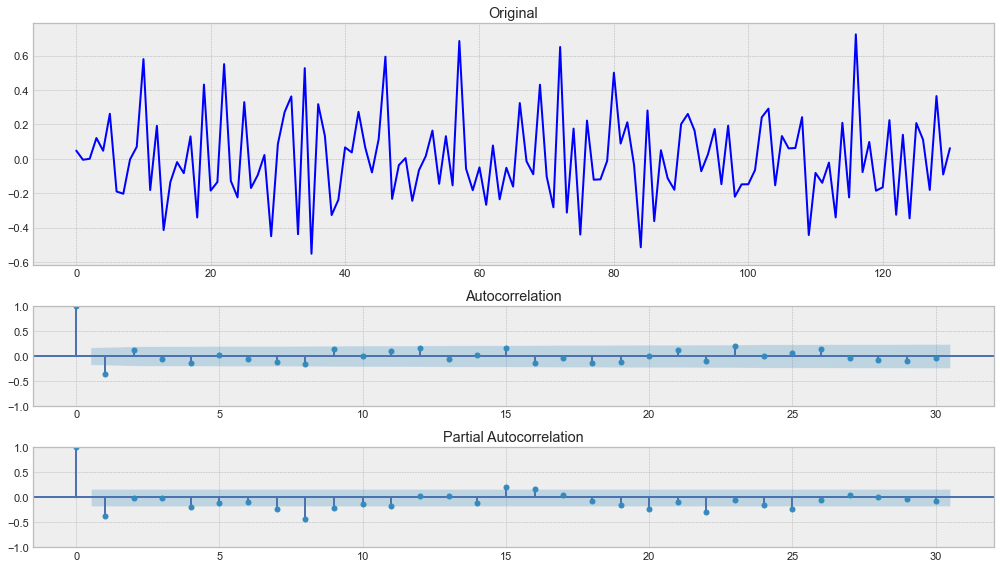

In [43]:
series_wind_dif = series_wind[1:] - series_wind[:-1]
tsplot(series_wind_dif)

Теперь тест Дики-Фуллера (p-value = 1.279969e-09) и графики коррелограмм отвергают гипотезу о нестационарности ряда

## Оценка качества

In [47]:
predictions = 12
wind_df = wind_month[:-predictions]

In [55]:
model_wind_val = Prophet(seasonality_mode='multiplicative')

model_wind_val.fit(wind_df)

future_wind_val = model_wind_val.make_future_dataframe(periods=predictions,
                                     freq='MS')
# finally, making predictions
forecast_wind_val = model_wind_val.predict(future_wind_val)
forecast_wind_val.tail()

23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
127,2021-08-01,4906.870707,3167.402094,4660.587444,4906.868627,4906.872990,-0.205332,-0.205332,-0.205332,-0.205332,-0.205332,-0.205332,0.0,0.0,0.0,3899.335520
128,2021-09-01,4934.069706,3590.570820,5041.062225,4934.067120,4934.072525,-0.124400,-0.124400,-0.124400,-0.124400,-0.124400,-0.124400,0.0,0.0,0.0,4320.271300
129,2021-10-01,4960.391318,4332.411863,5836.779030,4960.388264,4960.394679,0.026390,0.026390,0.026390,0.026390,0.026390,0.026390,0.0,0.0,0.0,5091.294992
130,2021-11-01,4987.590317,4784.082501,6295.631396,4987.586763,4987.594124,0.115789,0.115789,0.115789,0.115789,0.115789,0.115789,0.0,0.0,0.0,5565.098498
131,2021-12-01,5013.911928,5631.210951,7110.040038,5013.907890,5013.916287,0.280492,0.280492,0.280492,0.280492,0.280492,0.280492,0.0,0.0,0.0,6420.275823


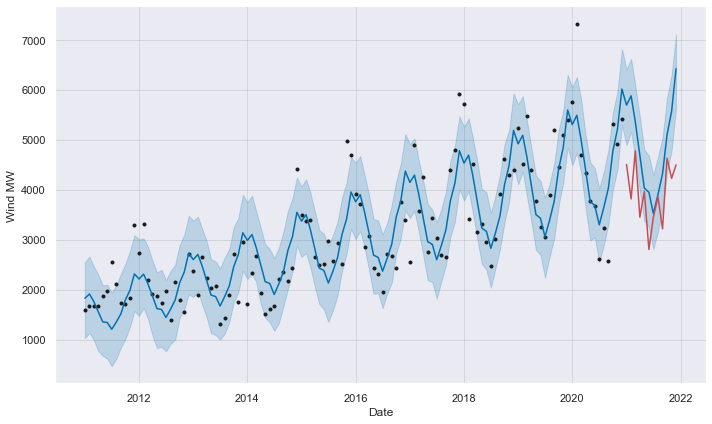

In [56]:
fig = model_wind_val.plot(forecast_wind_val, xlabel='Date',
                 ylabel=r'Wind MW')

plt.plot(wind_month[-predictions:].ds, wind_month[-predictions:].y, color='r')
plt.show()

In [57]:
error = mean_absolute_percentage_error(wind_month[-predictions:]['y'], forecast_wind_val[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 29.76%


Ошибка получилась конечно большая, можно предположить что именно за последний год выработка сократилась из-за сокращения потребления электроэнергии из-за коронавирусных локдаунов, а также из-за низкой цены на газ, из-за чего выгоднее генерировать электроэнергию на ТЭС.

## Предсказание на год вперед

In [58]:
model_wind = Prophet(seasonality_mode='multiplicative')

model_wind.fit(wind_month)

future_wind = model_wind.make_future_dataframe(periods=12,
                                     freq='MS')
# finally, making predictions
forecast_wind = model_wind.predict(future_wind)
forecast_wind.tail()

23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
139,2022-08-01,4761.581930,3079.974941,4716.089517,4760.580715,4762.726463,-0.177567,-0.177567,-0.177567,-0.177567,-0.177567,-0.177567,0.0,0.0,0.0,3916.080319
140,2022-09-01,4781.708616,3360.501161,4996.177854,4780.424511,4783.088191,-0.129797,-0.129797,-0.129797,-0.129797,-0.129797,-0.129797,0.0,0.0,0.0,4161.059245
141,2022-10-01,4801.186054,4219.203189,5813.782328,4799.649802,4802.817208,0.045945,0.045945,0.045945,0.045945,0.045945,0.045945,0.0,0.0,0.0,5021.777673
142,2022-11-01,4821.312741,4597.466892,6155.312312,4819.550423,4823.268641,0.110147,0.110147,0.110147,0.110147,0.110147,0.110147,0.0,0.0,0.0,5352.367219
143,2022-12-01,4840.790179,5249.844767,6947.372825,4838.775952,4843.121907,0.267366,0.267366,0.267366,0.267366,0.267366,0.267366,0.0,0.0,0.0,6135.053905


In [59]:
plot_plotly(model_wind, forecast_wind)

In [60]:
plot_components_plotly(model_wind, forecast_wind)

Исходя из графиков, модель предсказала рост мощности вырабатываемой электроэнергии ветряными мельницами в Германии. В то же время, сохраняется сезонность потребности в электроэнергии (летом потребление меньше, зимой больше). Учитывая войну и отказ Германии от российского газа, серию взрывов на газопроводах «Северный поток» а также отказ Германии от развития ядерной энергетики после аварии на АЭС Фукусима-1, думаю что прогноз на 2022 верный, а может быть даже и немного заниженный)